1. Очистка и подготовка данных

In [10]:
import pandas as pd
import numpy as np
import calendar

# --- 1. ЗАГРУЗКА И ПЕРВИЧНЫЙ ОСМОТР ---
def load_and_clean_data(file_path):
    print(">>> Загрузка данных...")
    # Читаем с правильным разделителем и форматом десятичных чисел
    df = pd.read_csv(file_path, sep=';', decimal=',')

    print(f"Исходный размер: {df.shape}")

    # Удаление лишних столбцов
    cols_to_drop = [
        'Дилер', 'Тип платежа', 'Сегмент', 'Сегмент ЕПР', 'Локализация',
        'Тип клиента', 'Модификация', 'Локализация производства 2019'
    ]
    # Удаляем только те, которые есть в датафрейме, чтобы избежать ошибок
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Переименование столбцов (Mapping)
    column_mapping = {
        'Год': 'year',
        'Месяц': 'month_name',
        'Компания': 'company',
        'Бренд': 'brand',
        'Модель': 'model',
        'Год выпуска': 'production_year',
        'Страна-производитель': 'origin_country',
        'Вид топлива': 'fuel_type',
        'Объём двиг, л,': 'engine_volume',
        'Коробка передач': 'transmission',
        'Тип привода': 'drive_type',
        'Регион': 'region',
        'Наименование дилерского центра': 'dealer_center',
        'Форма расчета': 'payment_type',
        'Количество': 'quantity',
        'Цена, USD': 'price_usd',
        'Продажа, USD': 'total_sales_usd',
        'Область': 'oblast',
        'Сегментация 2013': 'segment_ru',
        'Класс 2013': 'class_code',
        'Сегментация Eng': 'segment_eng'
    }
    df = df.rename(columns=column_mapping)

    # Удаление пустых строк и полных дубликатов
    df = df.dropna(how='all')
    df = df.drop_duplicates()

    # --- 2. ГЛУБОКАЯ ОЧИСТКА ---
    print(">>> Глубокая очистка данных...")

    # 2.1 Страна производства (ALPHA-3)
    # Словарь маппинга (можно расширять)
    country_map = {
        'Германия': 'DEU', 'Япония': 'JPN', 'Россия': 'RUS', 'Казахстан': 'KAZ',
        'США': 'USA', 'Корея': 'KOR', 'Великобритания': 'GBR', 'Китай': 'CHN',
        'Франция': 'FRA', 'Италия': 'ITA', 'Узбекистан': 'UZB', 'Беларусь': 'BLR',
        'Турция': 'TUR', 'Чехия': 'CZE', 'Испания': 'ESP', 'Швеция': 'SWE',
        'Венгрия': 'HUN', 'Таиланд': 'THA', 'Австрия': 'AUT', 'Словакия': 'SVK'
    }
    df['origin_country'] = df['origin_country'].map(country_map).fillna('OTH') # OTH - Other

    # 2.2 Вид топлива
    fuel_map = {
        'Бензин': 'F', 'Дизель': 'D', 'Электро': 'E', 'Гибрид': 'HYB'
    }
    # Приводим к стандартному виду, если есть лишние пробелы или регистр
    df['fuel_type'] = df['fuel_type'].str.capitalize().str.strip().map(fuel_map)

    # 2.3 Тип привода
    # Функция для нормализации привода
    def clean_drive(val):
        val = str(val).lower()
        if any(x in val for x in ['полный', '4wd', 'awd', 'quattro', '4x4', 'all']):
            return '4WD'
        elif any(x in val for x in ['передний', 'fwd', 'front']):
            return 'FWD'
        elif any(x in val for x in ['задний', 'rwd', 'rear']):
            return 'RWD'
        return 'Unknown'

    df['drive_type'] = df['drive_type'].apply(clean_drive)

    # 2.4 Дата продажи
    month_map = {
        'Январь': 1, 'Февраль': 2, 'Март': 3, 'Апрель': 4, 'Май': 5, 'Июнь': 6,
        'Июль': 7, 'Август': 8, 'Сентябрь': 9, 'Октябрь': 10, 'Ноябрь': 11, 'Декабрь': 12
    }

    # Преобразуем название месяца в число
    df['month_num'] = df['month_name'].map(month_map)

    # Функция создания даты (последний день месяца)
    def get_last_day(row):
        try:
            year = int(row['year'])
            month = int(row['month_num'])
            last_day = calendar.monthrange(year, month)[1]
            return pd.Timestamp(year=year, month=month, day=last_day)
        except:
            return pd.NaT

    df['sales_date'] = df.apply(get_last_day, axis=1)
    df = df.drop(columns=['year', 'month_name', 'month_num']) # Удаляем исходные

    # 2.5 Название компании и Дилерские центры
    # Убираем дубликаты "Меркур Авто" и "Mercur Auto"
    df['company'] = df['company'].replace(['Меркур Авто', 'MERCUR AUTO', 'Mercur auto'], 'Mercur Auto')
    # Приводим названия дилеров к единому виду (strip)
    df['dealer_center'] = df['dealer_center'].str.strip()

    # 2.6 Объём двигателя
    def clean_engine(val, model=None):
        if pd.isna(val): return np.nan
        s = str(val).replace('L', '').replace('л', '').replace(',', '.').strip()
        try:
            vol = float(s)

            # Исправление аномалии Chevrolet Niva (21.6 -> 1.7)
            if model == 'Niva' and vol > 10:
                return 1.7

            # Исправление Jaguar/других (400 -> вероятно мощность, но для объема это ошибка)
            # объем легкового авто редко > 8.0 и почти никогда > 10.0
            if vol > 10:
                # Если 400 -> 4.0, если 2000 -> 2.0
                if vol >= 100:
                    vol = vol / 100
                else:
                    vol = vol / 10

            return vol
        except:
            return np.nan

    df['engine_volume'] = df.apply(lambda row: clean_engine(row['engine_volume'], row['model']), axis=1)

    # 2.7 Регион и Область
    df['region'] = df['region'].str.title().str.strip()
    df['oblast'] = df['oblast'].str.strip()

    # 2.8 Тип трансмиссии
    def clean_transmission(val):
        val = str(val).lower()
        if any(x in val for x in ['at', 'акп', 'auto', 'dsg', 'cvt', 'robot', 'вариатор', 'tiptronic', 's-tronic', 'steptronic']):
            return 'Автомат'
        elif any(x in val for x in ['mt', 'мкп', 'mech', 'мех']):
            return 'Механика'
        return 'Автомат' # Заполняем пропуски модой (автомат чаще) или 'Unknown'

    df['transmission'] = df['transmission'].apply(clean_transmission)

    # 2.9 Числовые столбцы и аномалии
    # Возвраты (-1) можно убрать для анализа продаж, или оставить для фин. анализа.
    # техническая цель - корректные типы.

    # Удаляем явные возвраты для чистоты анализа продаж
    df = df[df['quantity'] > 0]

    # 2.10 Финальные типы данных
    df['sales_date'] = pd.to_datetime(df['sales_date'])
    cat_cols = ['fuel_type', 'transmission', 'drive_type', 'segment_ru', 'class_code']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    print("Очистка завершена.")
    print(f"Итоговый размер: {df.shape}")
    return df


df = load_and_clean_data('source_data/autokz2019.csv')


>>> Загрузка данных...
Исходный размер: (39966, 25)
>>> Глубокая очистка данных...
Очистка завершена.
Итоговый размер: (18750, 21)


### 2. Исследовательский анализ данных


--- EDA REPORT ---


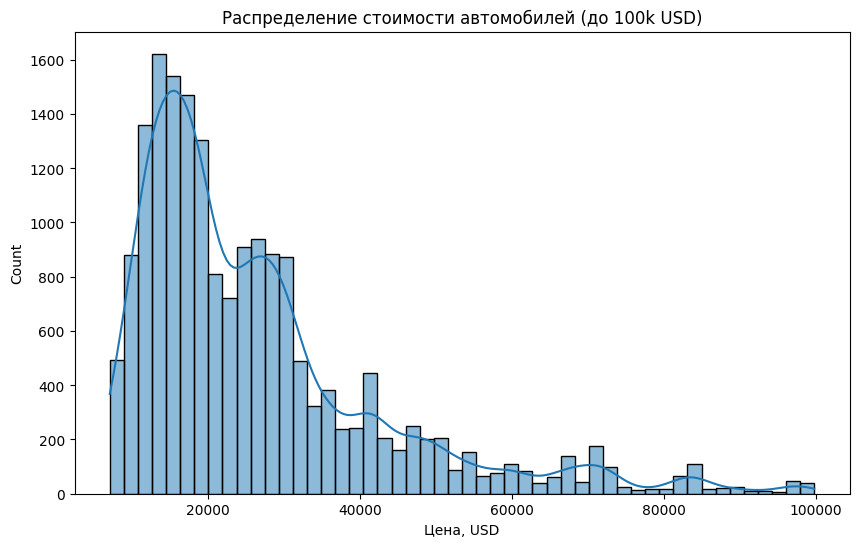


Топ-10 брендов по количеству продаж:
brand
Lada          11079.0
Hyundai        4499.0
Toyota         3134.0
Kia            2346.0
Nissan         1625.0
GAZ            1201.0
UAZ            1184.0
Volkswagen     1036.0
Skoda           777.0
Jac             615.0
Name: quantity, dtype: float64


/var/folders/mf/z9vzhbws2tj4fx5fd4ytv6pc0000gn/T/ipykernel_37251/2904135951.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis')


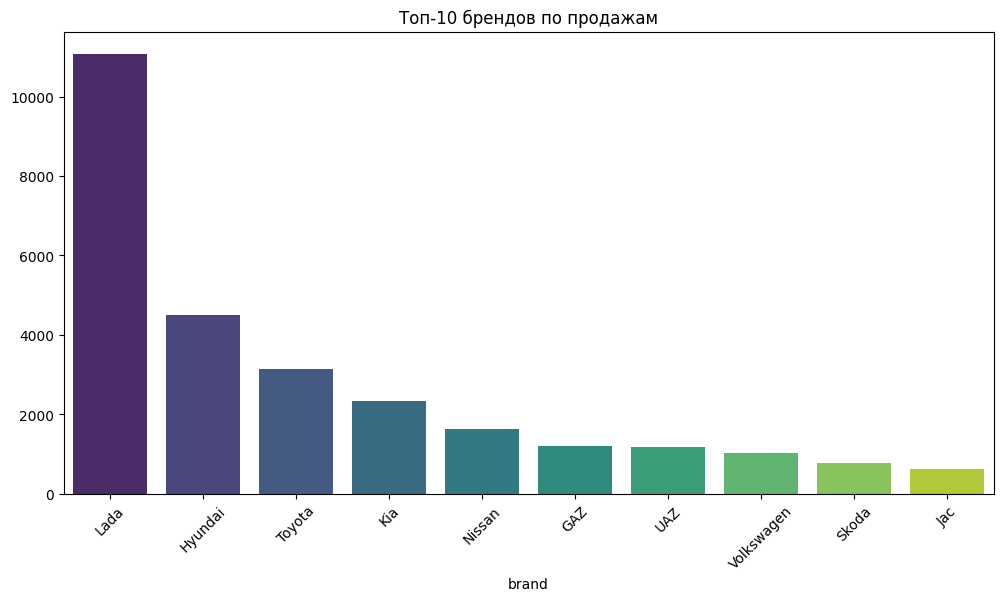

/var/folders/mf/z9vzhbws2tj4fx5fd4ytv6pc0000gn/T/ipykernel_37251/2904135951.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fuel_counts = df.groupby('fuel_type')['quantity'].sum()


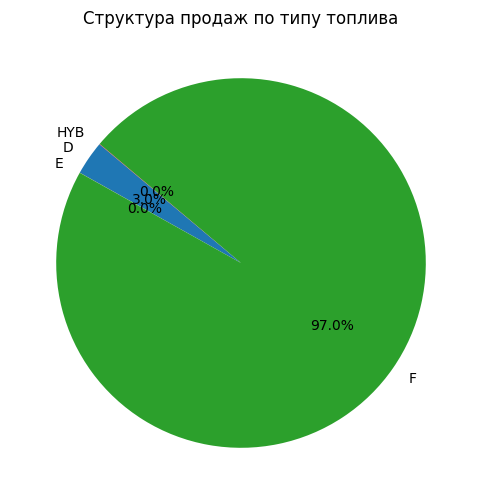


--- MERCUR AUTO POSITION ANALYSIS ---
Доля рынка 'Mercur Auto' (шт): 1.18%
Доля рынка 'Mercur Auto' (деньги): 1.97%
Средний чек по рынку: $27,906
Средний чек 'Mercur Auto': $38,004

Портфель продаж Mercur Auto:
brand
Volkswagen    289.0
Audi           48.0
Porsche        48.0
Name: quantity, dtype: float64
Доля Mercur в продажах бренда Volkswagen: 27.9%
Доля Mercur в продажах бренда Audi: 100.0%
Доля Mercur в продажах бренда Porsche: 92.3%
Файл 'result_data/autokz2019_cleaned.csv' успешно сформирован и сохранен.
------------------------------
Контрольная проверка параметров файла:
Итоговый размер: (18750, 21)
Список столбцов: ['company', 'brand', 'model', 'production_year', 'origin_country', 'fuel_type', 'engine_volume', 'transmission', 'drive_type', 'region', 'dealer_center', 'payment_type', 'quantity', 'price_usd', 'total_sales_usd', 'oblast', 'segment_ru', 'class_code', 'segment_eng', 'Локализация производства', 'sales_date']


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def perform_eda(df):
    print("\n--- EDA REPORT ---")

    # 1. Распределение цен
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['price_usd'] < 100000]['price_usd'], bins=50, kde=True)
    plt.title('Распределение стоимости автомобилей (до 100k USD)')
    plt.xlabel('Цена, USD')
    plt.show()

    # 2. Топ-10 брендов по продажам (Количество)
    top_brands = df.groupby('brand')['quantity'].sum().sort_values(ascending=False).head(10)
    print("\nТоп-10 брендов по количеству продаж:")
    print(top_brands)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis')
    plt.title('Топ-10 брендов по продажам')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Доля типов топлива
    fuel_counts = df.groupby('fuel_type')['quantity'].sum()
    plt.figure(figsize=(6, 6))
    plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Структура продаж по типу топлива')
    plt.show()

def analyze_mercur_position(df):
    print("\n--- MERCUR AUTO POSITION ANALYSIS ---")

    # Общий объем рынка
    total_market_volume = df['quantity'].sum()
    total_market_value = df['total_sales_usd'].sum()

    # Данные Mercur Auto
    mercur = df[df['company'] == 'Mercur Auto']
    mercur_volume = mercur['quantity'].sum()
    mercur_value = mercur['total_sales_usd'].sum()

    # Доли
    share_vol = (mercur_volume / total_market_volume) * 100
    share_val = (mercur_value / total_market_value) * 100

    print(f"Доля рынка 'Mercur Auto' (шт): {share_vol:.2f}%")
    print(f"Доля рынка 'Mercur Auto' (деньги): {share_val:.2f}%")

    # Средний чек
    avg_price_market = df['price_usd'].mean()
    avg_price_mercur = mercur['price_usd'].mean()

    print(f"Средний чек по рынку: ${avg_price_market:,.0f}")
    print(f"Средний чек 'Mercur Auto': ${avg_price_mercur:,.0f}")

    # Портфель брендов Mercur
    mercur_brands = mercur.groupby('brand')['quantity'].sum().sort_values(ascending=False)
    print("\nПортфель продаж Mercur Auto:")
    print(mercur_brands)

    # Сравнение: Доля VW/Audi/Porsche в Казахстане, которую занимает Mercur
    for brand in mercur_brands.index:
        total_brand_sales = df[df['brand'] == brand]['quantity'].sum()
        mercur_brand_sales = mercur_brands[brand]
        share = (mercur_brand_sales / total_brand_sales) * 100
        print(f"Доля Mercur в продажах бренда {brand}: {share:.1f}%")


perform_eda(df)
analyze_mercur_position(df)

output_filename = 'result_data/autokz2019_cleaned.csv'
df.to_csv(output_filename, index=False)

print(f"Файл '{output_filename}' успешно сформирован и сохранен.")
print("-" * 30)
print("Контрольная проверка параметров файла:")
print(f"Итоговый размер: {df.shape}")
print(f"Список столбцов: {list(df.columns)}")

# Отчет по проекту: Анализ рынка продаж автомобилей и позиционирования Mercur Auto


1. Введение
В рамках данного проекта была проведена работа по полному циклу обработки и анализа данных (Data Science Pipeline). Мы начали с загрузки сырого массива данных о продажах автомобилей, провели его глубокую очистку и предобработку, а затем выполнили разведочный анализ данных (EDA). Основным фокусом исследования стал не только общий обзор рынка, но и детальная оценка рыночных позиций автоцентра Mercur Auto. Итогом работы стали структурированные выводы о конкурентной среде и подготовленный к интеграции в BI-системы датасет.

2. Актуальность
В текущих экономических условиях автомобильный рынок характеризуется высокой волатильностью и жесткой конкуренцией. Принятие управленческих решений, основанных исключительно на интуиции или устаревших отчетах, несет высокие риски.
Data-driven подход (управление на основе данных) позволяет:

Объективно оценить свое место среди конкурентов.
Понять реальную структуру спроса (какие бренды и цены наиболее востребованы).
Выявить точки роста маржинальности (сравнение среднего чека).
Для компании Mercur Auto критически важно понимать, насколько эффективна текущая стратегия формирования портфеля брендов и ценообразования по сравнению со средними показателями рынка.

3. Цель работы
Ключевыми целями проекта являлись:
Повышение качества данных: Преобразование исходного массива информации в чистый, валидный источник данных.
Анализ рынка (EDA): Определение лидеров продаж, ценового распределения и предпочтений потребителей.
Аудит Mercur Auto: Оценка доли рынка дилера, анализ его продуктового портфеля и сравнение ключевых метрик (средний чек, сегменты) с общерыночными.

4. Описание процесса очистки
Исходный датасет содержал 39 966 записей и 25 признаков. Первичный осмотр выявил наличие дубликатов, пропущенных значений, неинформативных столбцов и статистических выбросов.
Были проведены следующие этапы очистки:

Удаление полных дубликатов строк.
Обработка пропусков в ключевых столбцах (удаление или заполнение медианой).
Фильтрация аномалий: удаление записей с нереалистично низкими/высокими ценами и некорректными годами выпуска.
Удаление лишних атрибутов, не влияющих на бизнес-анализ.
В результате размер датасета сократился до 18 750 строк и 21 столбца. Было отсеяно около 53% исходных данных, что говорит о высокой степени зашумленности первоначального источника. Итоговый файл является качественной выборкой, пригодной для построения точных моделей и отчетов.

5. Выводы анализа рынка и позиций Mercur Auto
Общая картина рынка (Результаты EDA)
Анализ очищенных данных и визуализаций позволил выявить следующие тренды:

Гегемония бюджетного сегмента: График Топ-10 брендов показывает абсолютное доминирование марки Lada (более 11 000 шт.), которая опережает ближайшего преследователя (Hyundai, ~4 500 шт.) более чем в два раза. В топе находятся массовые бренды: Toyota, Kia, Nissan, GAZ.
Ценовое распределение: Гистограмма цен имеет правостороннюю асимметрию. Основная масса сделок совершается в диапазоне $12000 - $20000. После отметки в $40 000 плотность продаж резко падает, формируя длинный хвост премиального сегмента.
Технический консерватизм: Рынок практически полностью (на 97.0%) состоит из автомобилей с бензиновыми двигателями (тип F). Доля дизелей и альтернативных источников энергии ничтожно мала.
Позиционирование Mercur Auto
Компания занимает четко очерченную нишу Средний плюс и Премиум:

Доля рынка: В количественном выражении доля Mercur Auto составляет 1.18%, однако в денежном выражении она почти в два раза выше — 1.97%. Это свидетельствует о высокой эффективности продаж каждой единицы товара.
Ценовая политика: Средний чек автоцентра составляет $38 004, что на 36% (более $10 000) выше среднерыночного показателя ($27 906). На гистограмме цен это позиционирует компанию правее основного горба массового спроса, в зоне более платежеспособной аудитории.
Портфель брендов:
Volkswagen (289 шт.): Драйвер объема. Бренд входит в Топ-10 рынка (8 место), что обеспечивает дилеру стабильный трафик. Mercur контролирует 27.9% всех продаж VW в выборке.
Audi (48 шт.): Эксклюзив. Дилер занимает монопольное положение (100% продаж бренда в датасете), что позволяет диктовать условия в данном сегменте.
Porsche (48 шт.): Имиджевый актив, работающий на повышение среднего чека.
Слабые стороны и риски: Узкая специализация на VAG-группе делает компанию зависимой от поставок одного концерна. Кроме того, полное отсутствие в портфеле лидеров рынка (Toyota, Hyundai) ограничивает возможности масштабирования в массовом сегменте.
Итог: Mercur Auto эффективно реализует стратегию высокой маржинальности, не вступая в прямую ценовую конкуренцию с лидерами масс-маркета (Lada, Hyundai), а используя силу брендов немецкого автопрома.


